# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [1]:
from cesnet_datazoo.datasets import CESNET_QUIC22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS")

Prepare the dataset with config and see its columns.

In [2]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)
data_df = dataset.get_train_df()
data_df.columns

Loading data from dataloader


100%|██████████| 521/521 [00:21<00:00, 23.94it/s] 


Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Get only the columns that are needed for clustering.

In [3]:
import numpy as np

features_array = data_df[["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION"]].to_numpy()
correct_clusters_array = data_df[["APP"]].to_numpy()

## Analysis

## Preprocessing

Define a pipeline for preprocessing.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Clustering

Define function for different methods of clustering.

In [5]:
from sklearn.cluster import HDBSCAN

def hdbscan_clustering(data, min_samples=5):
    return HDBSCAN(min_samples=min_samples).fit(data)

Perform DBSCAN clustering.

In [12]:
model = hdbscan_clustering(preprocessed_array, 3)
labels = model.labels_[:]

Remove outliers.

In [13]:
outliers = np.where(model.labels_ == -1)
# no_outliers_array = np.delete(preprocessed_array, outliers, axis=0)
# no_outliers_clusters_app = np.delete(correct_clusters_array, outliers)
# no_outliers_labels = np.delete(model.labels_, outliers)

print(f"Number of outliers: {len(outliers[0])}")

Number of outliers: 25173


## Evaluation

Define function for evaluation.

In [14]:
from sklearn.metrics import fowlkes_mallows_score, silhouette_score

def fowlkes_mallows_index(labels_true, labels_pred):
    return fowlkes_mallows_score(labels_true, labels_pred)

def silhouette_index(data, labels):
    return silhouette_score(data, labels)

Evaluate the clustering.

In [15]:
# "FM index:", fowlkes_mallows_index(test_array, labels)

## Visualization

Define function for visualization.

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_clusters(data, labels, axis=True):
    # Define a colormap
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab20', len(unique_labels))
    colormap = ListedColormap(colors(np.arange(len(unique_labels))))

    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=colormap, s=1)
    
    # Add a color bar
    cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
    cbar.set_label('Cluster Label')
    cbar.set_ticks(unique_labels)
    
    plt.axis(axis)

    plt.show()

Visualize the clusters.

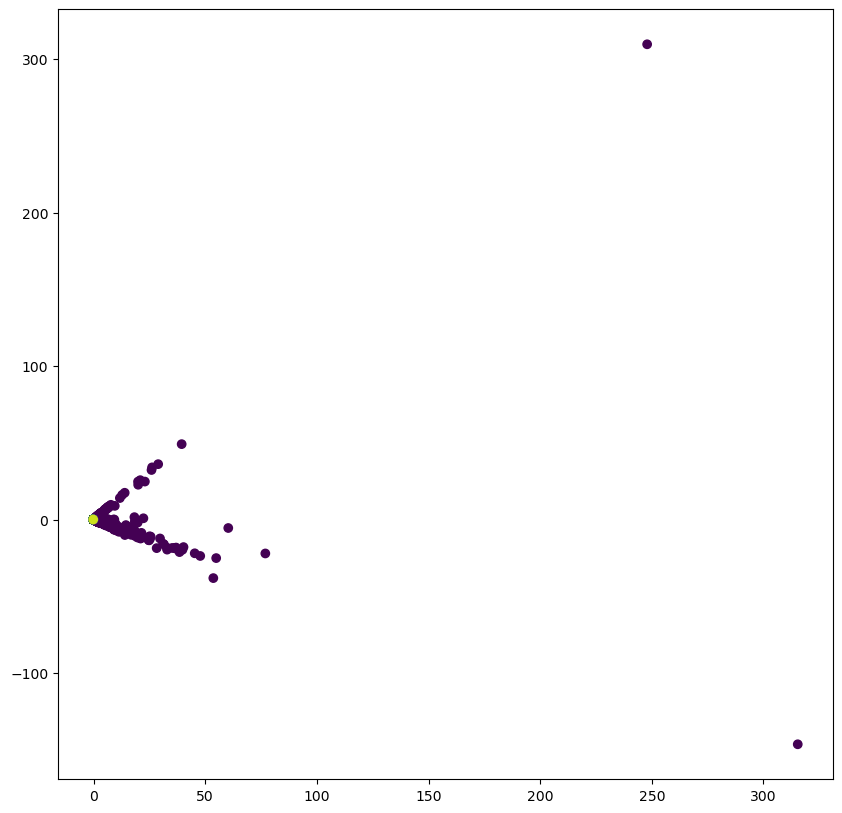

In [17]:
plot_clusters(preprocessed_array, labels)

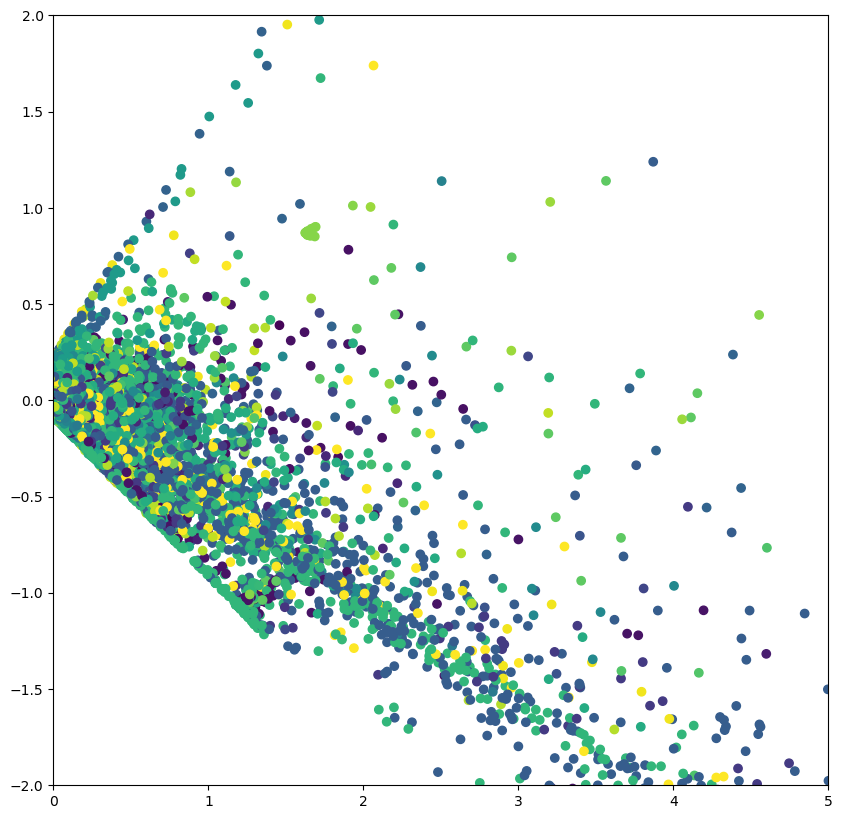

In [24]:
plot_clusters(preprocessed_array, correct_clusters_array, [0, 5, -2, 2])